## Firsts tests with h5py and FLAMINGO data

In [2]:
import h5py
import swiftsimio as sw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm import tqdm
import os 

In [ ]:
path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    M200m = handle["SO/200_mean/TotalMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    R200m = handle["SO/200_mean/SORadius"][:] #radii, centres and positions are in Mpc
    centre = handle["InputHalos/HaloCentre"][...]

Largest 200m mass: 3.835e+15 Msol
Or 15.583751678466797 in logspace


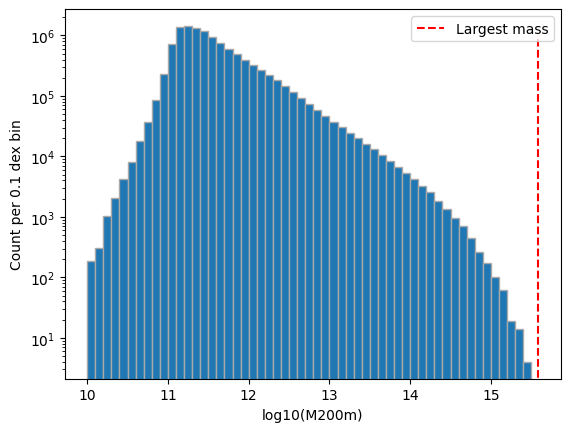

In [2]:
print(f'Largest 200m mass: {np.max(M200m):.3e} Msol')

logM200m = np.log10(M200m[M200m >= 1e10])
max_dex = np.max(logM200m)
print(f'Or {max_dex} in logspace')

fig,ax = plt.subplots()
ax.hist(logM200m,bins=np.arange(10,max_dex,0.1),log=True,edgecolor='darkgrey')
# ax.tick_params(which='both')
ax.set(xlabel = 'log10(M200m)', ylabel = 'Count per 0.1 dex bin')
ax.vlines(np.max(logM200m),0,1e6,label='Largest mass', linestyles='--', colors='red')
ax.legend()
plt.show()

In [3]:
##Example 2

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    Mstar = handle["SO/200_mean/StellarMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    Mgas = handle["SO/200_mean/GasMass"][:]*1e10 #mass is stored in units of 1e10 solar masses

#where arg to ignore 0's
logMstar = np.log10(Mstar,where=Mstar!=0)
logMgas = np.log10(Mgas,where=Mgas!=0)
logM200m = np.log10(M200m,where=M200m!=0)

nonzero = (logMgas >= 10) * (logMstar >= 10 ) 
bar_frac = (Mgas[nonzero] + Mstar[nonzero]) / (M200m[nonzero])


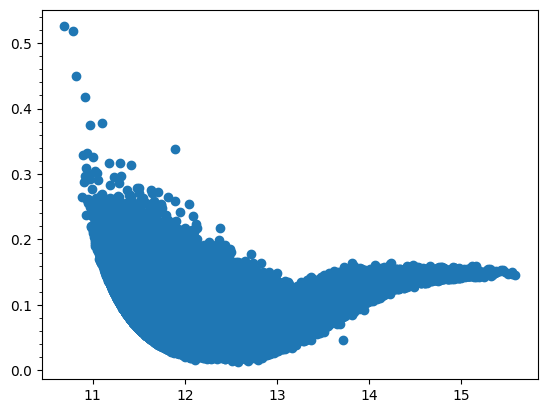

In [4]:
import matplotlib.ticker as ticker
fig,ax = plt.subplots()
ax.scatter(logM200m[nonzero], bar_frac)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.show()

In [ ]:
#Example 3

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    centre = handle["InputHalos/HaloCentre"][...]
    Stellarmass = handle['ExclusiveSphere/50kpc/StellarMass'][:] * 1e10


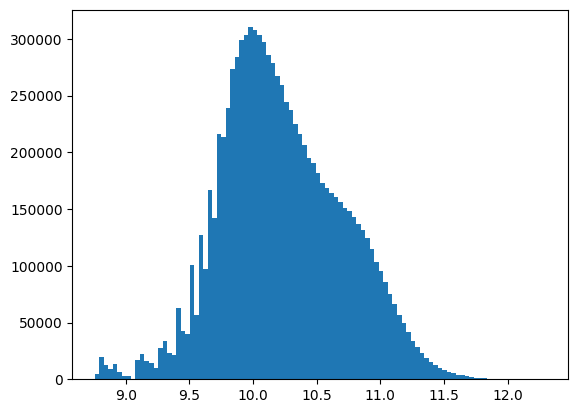

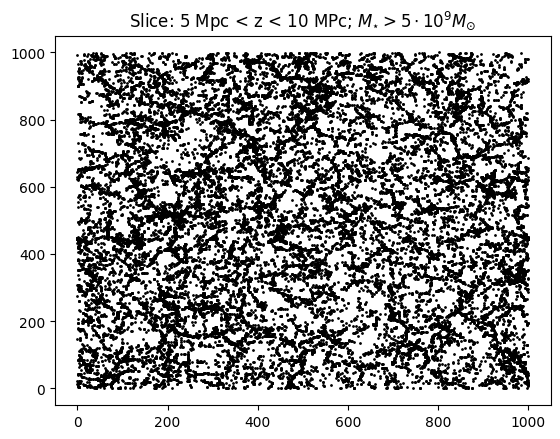

In [44]:
logStellarMass = np.log10(Stellarmass[Stellarmass != 0])

plt.figure()
plt.hist(logStellarMass,bins=100)
plt.show()

centre_x, centre_y, centre_z = centre[Stellarmass > 5*1e9].T
zmask = (5 < centre_z) * (centre_z < 10)
plt.figure()
plt.scatter(centre_x[zmask], centre_y[zmask], s = 1, c='black')
plt.title(r'Slice: 5 Mpc < z < 10 MPc; $M_{\star} > 5\cdot10^9 M_{\odot}$')
plt.show()

In [3]:
## Example 4
import os 

path_DMO = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_DMO, "r") as handle:
    # M200m = handle["SO/200_mean/TotalMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    R200m = handle["SO/200_mean/SORadius"][:][0] #radii, centres and positions are in Mpc
    R500c = handle["SO/500_crit/SORadius"][:][0]
    centre = handle["InputHalos/HaloCentre"][...][0]
    HaloCatalogueIndex=handle["InputHalos/HaloCatalogueIndex"][:][0] # To match to particles

print(HaloCatalogueIndex)

snapshot_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/snapshots/flamingo_0077"
membership_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/membership_0077"



12283760


In [ ]:
from tqdm import tqdm 

def extract_galaxy_particles(soap_path, snapshot_path, membership_path,PartType = 1, which_halo = 0):
    PartType_dict = {0:'Gas',1:'DarkMatter',4:'Star',5:'BlackHole'}
    single_parttype = isinstance(PartType, int)

    with h5py.File(soap_path, "r") as handle:
        print(f'Looking at halo {which_halo}')
        HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][which_halo] # To match to particles
        print(f'HaloCatalogueIndex: {HaloCatalogueIndex}')

        NumPart = handle[f"InputHalos/NumberOfBoundParticles"][which_halo]
        # if single_parttype:
        #     NumPart = handle[f"InputHalos/NumberOfBoundParticles"][which_halo]
        #     # Optionally add other particle types here
        # else:
        #     # More than one particle type -> use dictionary comprehension
        #     NumPart = {pt: handle[f"SO/200_mean/NumberOf{PartType_dict[pt]}Particles"][which_halo] for pt in PartType}


    if single_parttype:
        Particle_Coords = np.zeros((NumPart,3))

        n_found = 0 #tracker for how many particles have been found so far
        for i in tqdm(range(len(os.listdir(membership_path)))):
            snapshot_path_i = os.path.join(snapshot_path,f"flamingo_0077.{i}.hdf5")
            membership_path_i = os.path.join(membership_path,f"membership_0077.{i}.hdf5")
            
            with h5py.File(membership_path_i,'r') as membership_handle:
                GroupNr_bound = membership_handle[f'/PartType{PartType}/GroupNr_bound'][:]

            #Select particles belonging to desired Halo
            mask = GroupNr_bound == HaloCatalogueIndex  # match the halo index to the membership file
            new_found = np.sum(mask)
            if new_found == 0:
                continue # skip to next file if no particles found
        
            with h5py.File(snapshot_path_i, 'r') as snapshot_handle:
                Coords = snapshot_handle[f'PartType{PartType}/Coordinates'][mask] # only correct if masked, otherwise use ...
            # Particle_Coords = np.append(Particle_Coords, Coords) #bad!
            Particle_Coords[n_found:n_found+new_found] = Coords
            n_found += new_found

            if n_found == NumPart: # found all particles
                print('Found all particles, stopping search.')
                break

        return Particle_Coords

    #Multiple PartTypes at the same time
    else:        
        Particle_Coords = np.zeros((NumPart,3))
        Particle_Types = np.zeros(NumPart) # to keep track of which particle is of which type

        num_found = 0
        for i in tqdm(range(len(os.listdir(membership_path)))):
            snapshot_path_i = os.path.join(snapshot_path,f"flamingo_0077.{i}.hdf5")
            membership_path_i = os.path.join(membership_path,f"membership_0077.{i}.hdf5")

            new_found_tot = 0 # no discrimination between parttypes here
            for PType in PartType:
                new_found_ptype = 0 # tracker for how many new particles of this type found in this membership file
                with h5py.File(membership_path_i,'r') as membership_handle:
                    GroupNr_bound = membership_handle[f'/PartType{PType}/GroupNr_bound'][:]
                    #Select desired Halo(es)
                    mask = GroupNr_bound == HaloCatalogueIndex
                    # HaloMasks[PType] = mask
                    new_found_ptype += np.sum(mask)
                
                if new_found_ptype == 0:
                    continue # skip to next PType if no particles of this type found
                
                with h5py.File(snapshot_path_i, 'r') as snapshot_handle:
                    Coords = snapshot_handle[f'PartType{PType}/Coordinates'][:][mask] #Immediately mask only to wanted haloes
                    # add in the right slice: from the total number found so far, to the total number found so far + the new ones found in this file so far
                    Particle_Coords[num_found + new_found_tot: num_found + new_found_tot + new_found_ptype] = Coords 
                    Particle_Types[num_found + new_found_tot: num_found + new_found_tot + new_found_ptype] = [PType] * new_found_ptype

                #update total num of new particles found in this membership file 
                new_found_tot += new_found_ptype
            num_found += new_found_tot

            if num_found == NumPart: 
                print('Found all particles, stopping search.')
                break

        return [Particle_Coords[mask] for mask in [(Particle_Types == ptype) for ptype in PartType]] # return as list of arrays, one per PartType, in the same order as input


In [74]:
test = [i for i in [j for j in range(10)]]
test

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Looking at halo 33314
HaloCatalogueIndex: 2224815


 31%|███▏      | 10/32 [02:30<05:31, 15.09s/it]

Found all particles, stopping search.


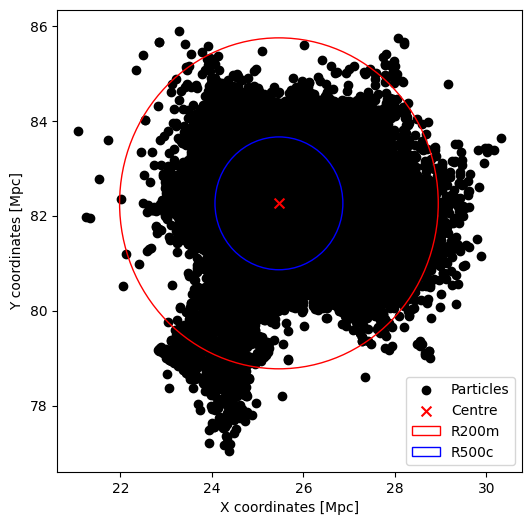

In [66]:
path_DMO = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"

# FLAMINGO_ROOT = "/net/hypernova/data2/FLAMINGO/L1000N1800/"
# DMO_ROOT = os.path.join(FLAMINGO_ROOT, "DMO_FIDUCIAL")
# HYDRO_ROOT = os.path.join(FLAMINGO_ROOT, "HYDRO_FIDUCIAL")
# print(os.path.join(HYDRO_ROOT, "SOAP-HBT", "halo_properties_0077.hdf5"))
# print(path_DMO)


with h5py.File(path_DMO, "r") as handle:
    which_halo = np.flatnonzero(handle["SO/200_mean/TotalMass"][:] > 1e5)[0] # Select halo with a mass that is large enough to matter
    R200m = handle["SO/200_mean/SORadius"][which_halo] #radii, centres and positions are in Mpc
    R500c = handle["SO/500_crit/SORadius"][which_halo]
    centre = handle["InputHalos/HaloCentre"][...][which_halo]

snapshot_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/snapshots/flamingo_0077"
membership_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/membership_0077"

Particle_Coords = extract_galaxy_particles(path_DMO, snapshot_path, membership_path, which_halo=which_halo, PartType=1)
x,y,z = Particle_Coords.T
centre_x,centre_y,centre_z = centre

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(x,y,c='black',label='Particles')
ax.scatter(centre_x,centre_y,marker='x',c='red',s=50,zorder=10,label='Centre')

Circle_200m = patches.Circle(xy = (centre_x,centre_y),radius = R200m, color='red',fill=False,label='R200m')
Circle_500c = patches.Circle(xy = (centre_x,centre_y),radius = R500c, color='blue',fill=False,label='R500c')
ax.add_patch(Circle_200m)
ax.add_patch(Circle_500c)

ax.set(xlabel='X coordinates [Mpc]',ylabel = 'Y coordinates [Mpc]')
plt.legend()
plt.show()

In [76]:
## Example 5

path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_HYDRO, "r") as handle:
    which_halo = np.flatnonzero(handle["SO/200_mean/TotalMass"][:] > 1e5)[0] # Select halo with a mass that is large enough to matter
    R200m = handle["SO/200_mean/SORadius"][:][which_halo] #radii, centres and positions are in Mpc
    R500c = handle["SO/500_crit/SORadius"][:][which_halo]
    centre = handle["InputHalos/HaloCentre"][...][which_halo]

snapshot_path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077"
membership_path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/membership_0077"


In [ ]:
# With this method I open the files only once and extract all the necessary parts at once: ~ twice as fast! Most importantly:
# I no longer append but make an array of the right size and use slicing to fill it
DMCoords, StarCoords = extract_galaxy_particles(path_HYDRO, snapshot_path_HYDRO, membership_path_HYDRO, PartType=(1,4), which_halo=which_halo)

Looking at halo 46441
HaloCatalogueIndex: 1813642


100%|██████████| 64/64 [02:07<00:00,  1.99s/it]


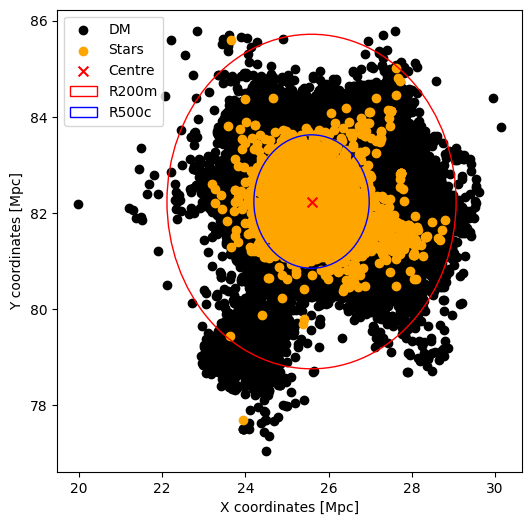

In [78]:
from matplotlib import patches

# Extract the indivual coordinates, easily done in 1 line due to how the particle coords were saved
DMx,DMy,_ = DMCoords.T
Starx,Stary,_ = StarCoords.T
centre_x,centre_y,_ = centre

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(DMx,DMy,c='black',label='DM')
ax.scatter(Starx,Stary,c='orange',label='Stars')
ax.scatter(centre_x,centre_y,marker='x',c='red',s=50,zorder=10,label='Centre')

Circle_200m = patches.Circle(xy = (centre_x,centre_y),radius = R200m, color='red',fill=False,label='R200m')
Circle_500c = patches.Circle(xy = (centre_x,centre_y),radius = R500c, color='blue',fill=False,label='R500c')
ax.add_patch(Circle_200m)
ax.add_patch(Circle_500c)

ax.set(xlabel='X coordinates [Mpc]',ylabel = 'Y coordinates [Mpc]')
plt.legend()
plt.show()